In [5]:
#!pip install --upgrade gensim --force-reinstall
from gensim.models import Word2Vec
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [6]:
splits = {'train': 'plain_text/train-00000-of-00001.parquet',
          'test': 'plain_text/test-00000-of-00001.parquet',
          'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
data = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
data_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["test"])
positive_reviews = data[data['label'] == 1].sample(1000)
negative_reviews = data[data['label'] == 0].sample(1000)
data = pd.concat([positive_reviews, negative_reviews]).sample(frac=1).reset_index(drop=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


In [8]:
print(data.head())

                                                text  label
0  The past few months I have collected Voyager s...      1
1  From the excellent acting of an extremely impr...      1
2  This is probably the worst excuse for televisi...      0
3  Guys and Dolls is a movie itching for a remake...      1
4  For those of you that don't that reference, cl...      1


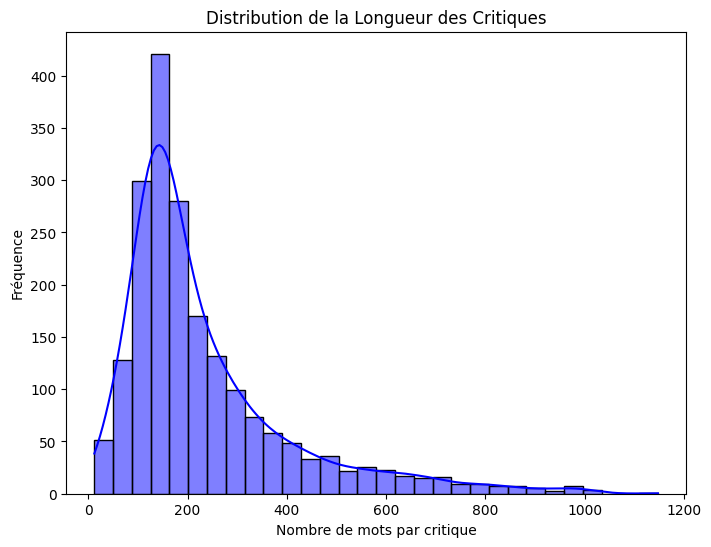

In [9]:
# Distribution de la longueur des critiques
data['review_length'] = data['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(data['review_length'], bins=30, kde=True, color='blue')
plt.title("Distribution de la Longueur des Critiques")
plt.xlabel("Nombre de mots par critique")
plt.ylabel("Fréquence")
plt.show()

In [10]:
#  PRÉTRAITEMENT
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import collections
from itertools import chain

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')


# Text cleaning function
def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# Apply text preprocessing
data['cleaned_tokens'] = data['text'].apply(preprocess_text)
data['cleaned_review'] = data['cleaned_tokens'].apply(lambda tokens: " ".join(tokens))

In [12]:
data['cleaned_tokens']

,cleaned_tokens
0,"[past, month, collected, voyager, season, dvd,..."
1,"[excellent, acting, extremely, impressive, cas..."
2,"[probably, worst, excuse, television, programm..."
3,"[guy, doll, movie, itching, remake, made, fort..."
4,"[reference, clubberin, fist, hitting, one, bod..."
...,...
1995,"[pandemonium, horror, movie, spoof, come, stup..."
1996,"[normally, sort, scared, horror, movie, movie,..."
1997,"[frailty, non, sensical, title, bill, paxton, ..."
1998,"[screen, adaptation, john, grisham, story, des..."


In [13]:
data['cleaned_review']

,cleaned_review
0,past month collected voyager season dvd video ...
1,excellent acting extremely impressive cast int...
2,probably worst excuse television programming s...
3,guy doll movie itching remake made forty eight...
4,reference clubberin fist hitting one body anyw...
...,...
1995,pandemonium horror movie spoof come stupid fun...
1996,normally sort scared horror movie movie except...
1997,frailty non sensical title bill paxton directs...
1998,screen adaptation john grisham story deserves ...


<ipython-input-14-2c4d435b58b6>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orig_counts, y=orig_words, palette='coolwarm')
<ipython-input-14-2c4d435b58b6>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=preproc_counts, y=preproc_words, palette='coolwarm')


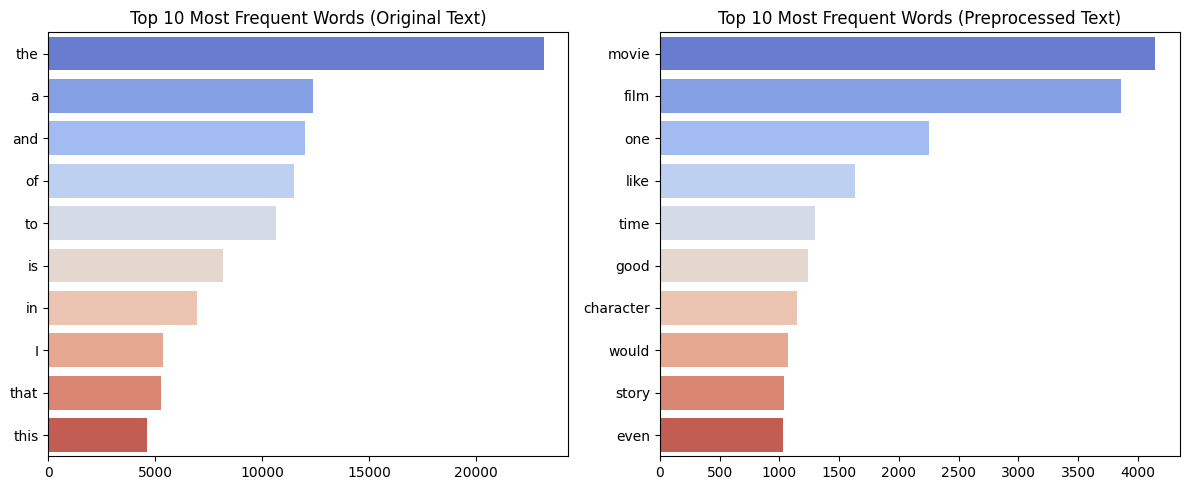

In [14]:
from collections import Counter

def get_word_frequencies(text_column):
    words = []
    for review in text_column:
        words.extend(review.split())
    return Counter(words)

# Get word frequencies for original and cleaned reviews
original_word_freq = get_word_frequencies(data['text'])
preprocessed_word_freq = get_word_frequencies(data['cleaned_review'])

# Get top 10 frequent words
original_common_words = original_word_freq.most_common(10)
preprocessed_common_words = preprocessed_word_freq.most_common(10)

orig_words = [word for word, count in original_common_words]
orig_counts = [count for word, count in original_common_words]

preproc_words = [word for word, count in preprocessed_common_words]
preproc_counts = [count for word, count in preprocessed_common_words]

# Plot word frequencies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=orig_counts, y=orig_words, palette='coolwarm')
plt.title('Top 10 Most Frequent Words (Original Text)')

plt.subplot(1, 2, 2)
sns.barplot(x=preproc_counts, y=preproc_words, palette='coolwarm')
plt.title('Top 10 Most Frequent Words (Preprocessed Text)')
plt.tight_layout()
plt.show()

In [15]:
y_train = data['label']
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_review'],
                                                    data['label'],
                                                    test_size=0.2,
                                                    random_state=42)
print(y_train.value_counts())
print(y_test.value_counts())

label
0    805
1    795
Name: count, dtype: int64
label
1    205
0    195
Name: count, dtype: int64


In [16]:
# 3. EXTRACTION DE CARACTÉRISTIQUES

# Convert text to numerical features using TF-IDF
#vectorizer = TfidfVectorizer(max_features=optimal_max_features)
vectorizer = TfidfVectorizer(max_features=8000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Word2Vec Embeddings
w2v_model = Word2Vec(sentences=data['cleaned_tokens'],
                     vector_size=500,
                     window=5,
                     min_count=5,
                     workers=4)

def get_w2v_vector(tokens, model, vector_size=500):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Compute Word2Vec embeddings
X_train_w2v = np.array([get_w2v_vector(tokens, w2v_model)
for tokens in data.loc[X_train.index, 'cleaned_tokens']])
X_test_w2v = np.array([get_w2v_vector(tokens, w2v_model)
for tokens in data.loc[X_test.index, 'cleaned_tokens']])

# Concatenate TF-IDF and Word2Vec features
X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_w2v))
X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_w2v))


<ipython-input-17-c4b0de11e3df>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


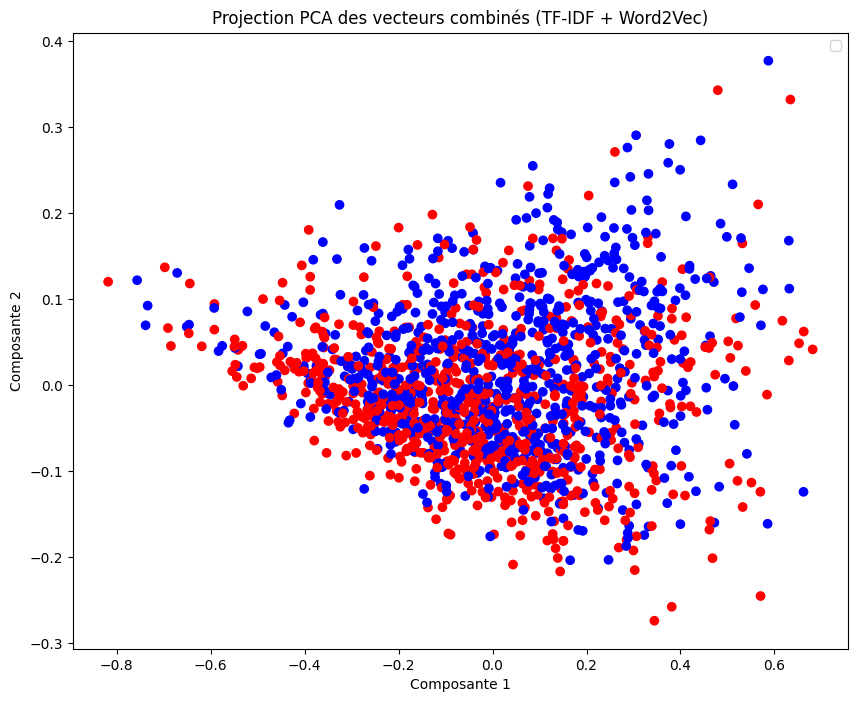

In [17]:
from sklearn.decomposition import PCA
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
w2v_pca = pca.fit_transform(X_train_combined)


colors = ['red' if label == 1 else 'blue' for label in y_train]
# Tracer le graphique
plt.figure(figsize=(10, 8))
plt.scatter(w2v_pca[:, 0], w2v_pca[:, 1], color=colors)

plt.title("Projection PCA des vecteurs combinés (TF-IDF + Word2Vec)")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.legend()
plt.show()

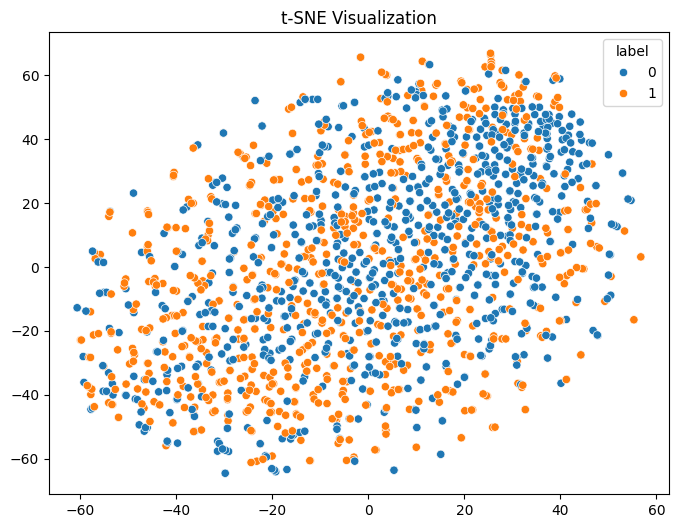

In [18]:

# t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
X_tsne = tsne.fit_transform(X_train_combined)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train)
plt.title("t-SNE Visualization")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


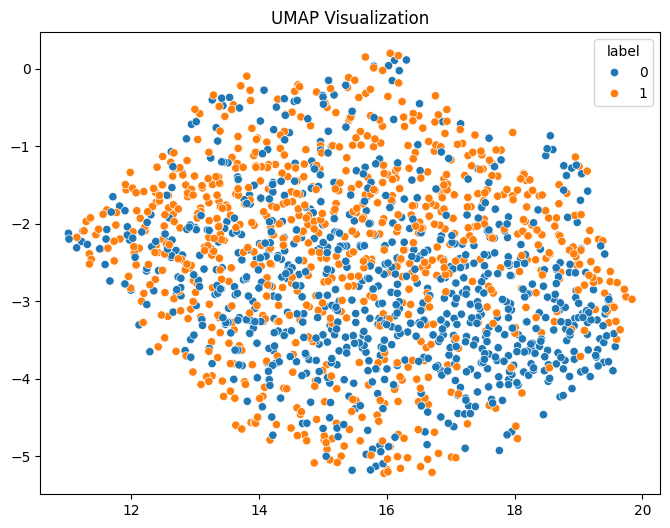

In [19]:
# UMAP Visualization
umap_model = umap.UMAP(n_components=2,
                       n_neighbors=18,
                       min_dist=0.3,
                       random_state=42)
X_umap = umap_model.fit_transform(X_train_combined)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_train)
plt.title("UMAP Visualization")
plt.show()

## Fonctions de training et d'évaluation

In [20]:
def train_model(model, train_loader, criterion, optimizer, epochs=15):
    loss_values = []
    acc_values = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calcul de l'accuracy
            predicted = outputs > 0  # La sortie brute (logits) comparée à 0
            correct += (predicted.squeeze() == targets).sum().item()
            total += targets.size(0)

        acc = correct / total  # Accuracy sur l'ensemble d'entraînement
        loss_values.append(total_loss / len(train_loader))  # Ajouter la perte moyenne
        acc_values.append(acc)  # Ajouter la précision

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {acc:.4f}")

    # Tracer les courbes de perte et de précision
    plt.figure(figsize=(12, 5))

    # Courbe de perte
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), loss_values, label='Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Perte au cours de l\'entraînement')
    plt.grid(True)

    # Courbe de précision
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), acc_values, label='Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Précision au cours de l\'entraînement')
    plt.grid(True)

    # Afficher les graphiques
    plt.tight_layout()
    plt.show()


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, criterion):
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            total_loss += loss.item()

            # Conversion en prédictions binaires (0 ou 1)
            predicted = (outputs > 0).int()  # Convertir en entiers
            all_preds.extend(predicted.squeeze().cpu().numpy())
            all_targets.extend(targets.int().cpu().numpy())  # Cible en entiers

    # Calcul des métriques sur l'ensemble des données
    acc = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)

    return acc, precision, recall, f1

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, test_loader):
    model.eval()  # Mode évaluation
    all_preds = []
    all_targets = []

    with torch.no_grad():  # Pas besoin de calculer les gradients pour l'évaluation
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predicted = outputs > 0  # On applique un seuil de 0 pour la classification binaire
            all_preds.extend(predicted.squeeze().cpu().numpy())  # Ajouter les prédictions
            all_targets.extend(targets.cpu().numpy())  # Ajouter les vraies valeurs

    # Calcul de la matrice de confusion
    cm = confusion_matrix(all_targets, all_preds)

    # Affichage de la matrice de confusion avec Seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vrais labels')
    plt.title('Matrice de confusion')
    plt.show()

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Fonction pour calculer l'accuracy
def binary_accuracy(preds, y):
    preds = torch.round(torch.sigmoid(preds))  # Convertir logits en 0 ou 1
    correct = (preds == y).float()  # Comparer avec y
    return correct.sum() / len(correct)

def train_model2(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss, running_train_acc = 0.0, 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            running_train_acc += binary_accuracy(outputs, y_batch).item()

        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_acc = running_train_acc / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        # ---- Validation ----
        model.eval()
        running_val_loss, running_val_acc = 0.0, 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)

                running_val_loss += val_loss.item()
                running_val_acc += binary_accuracy(val_outputs, y_val).item()

        avg_val_loss = running_val_loss / len(val_loader)
        avg_val_acc = running_val_acc / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    # ---- Affichage des courbes ----
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(train_losses, label="Train Loss", color="red")
    ax1.plot(val_losses, label="Val Loss", color="orange", linestyle="dashed")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")
    ax2.plot(train_accuracies, label="Train Acc", color="blue")
    ax2.plot(val_accuracies, label="Val Acc", color="cyan", linestyle="dashed")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.title("Training vs Validation Loss & Accuracy")
    plt.show()


## Mixture of experts (MoE)

In [22]:
class MoE(nn.Module):
    def __init__(self, input_dim, num_experts=2):
        super(MoE, self).__init__()
        self.experts = nn.ModuleList([nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        ) for _ in range(num_experts)])
        self.gate = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        gate_outputs = torch.softmax(self.gate(x), dim=1)
        expert_outputs = torch.cat([expert(x).unsqueeze(2) for expert in self.experts], dim=2)
        output = torch.sum(gate_outputs.unsqueeze(2) * expert_outputs, dim=2)
        return output.sum(dim=1, keepdim=True)

In [23]:
# Préparation des données
X_train2, X_val, y_train2, y_val = train_test_split(X_train_combined, y_train , test_size=0.2, random_state=42)

train_data = TensorDataset(torch.tensor(X_train2, dtype=torch.float32),
                           torch.tensor(y_train2.values, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(X_test_combined, dtype=torch.float32),
                          torch.tensor(y_test.values, dtype=torch.float32))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val.values, dtype=torch.float32)),
                        batch_size=32)


In [24]:
# Entraînement du modèle MoE
moe_model = MoE(input_dim=X_train2.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(moe_model.parameters(), lr=0.01)


Epoch 1/10 | Train Loss: 0.6755, Train Acc: 0.6102 | Val Loss: 0.6046, Val Acc: 0.6062
Epoch 2/10 | Train Loss: 0.2990, Train Acc: 0.8812 | Val Loss: 0.4018, Val Acc: 0.8250
Epoch 3/10 | Train Loss: 0.0562, Train Acc: 0.9891 | Val Loss: 0.5610, Val Acc: 0.7750
Epoch 4/10 | Train Loss: 0.0207, Train Acc: 0.9977 | Val Loss: 0.4046, Val Acc: 0.8344
Epoch 5/10 | Train Loss: 0.0049, Train Acc: 1.0000 | Val Loss: 0.4144, Val Acc: 0.8375
Epoch 6/10 | Train Loss: 0.0028, Train Acc: 1.0000 | Val Loss: 0.4271, Val Acc: 0.8313
Epoch 7/10 | Train Loss: 0.0020, Train Acc: 1.0000 | Val Loss: 0.4346, Val Acc: 0.8344
Epoch 8/10 | Train Loss: 0.0015, Train Acc: 1.0000 | Val Loss: 0.4431, Val Acc: 0.8281
Epoch 9/10 | Train Loss: 0.0012, Train Acc: 1.0000 | Val Loss: 0.4510, Val Acc: 0.8313
Epoch 10/10 | Train Loss: 0.0010, Train Acc: 1.0000 | Val Loss: 0.4569, Val Acc: 0.8313


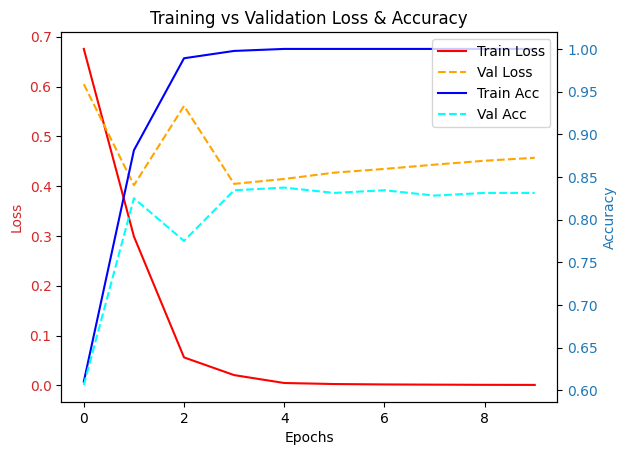

In [25]:
train_model2(moe_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


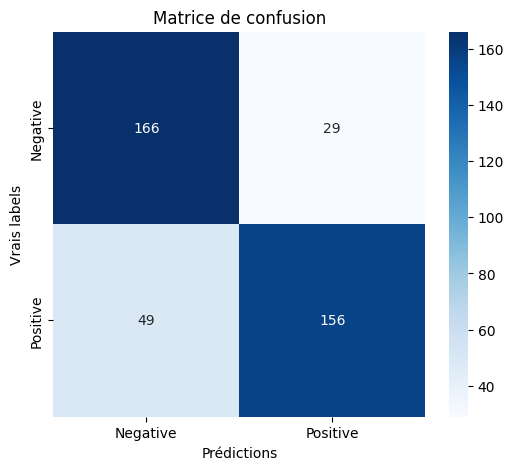

In [26]:
# Appel de la fonction pour afficher la matrice de confusion
plot_confusion_matrix(moe_model, test_loader)


In [27]:

# Évaluation du modèle MoE
moe_acc, moe_precision, moe_recall, moe_f1 = evaluate_model(moe_model, test_loader, criterion)


In [28]:
moe_acc

0.805

## MLP

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Définition du modèle MLP
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# Initialisation du modèle MLP
mlp_model = MLP(input_dim=X_train2.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)


Epoch 1/10 | Train Loss: 0.6932, Train Acc: 0.4875 | Val Loss: 0.6884, Val Acc: 0.5062
Epoch 2/10 | Train Loss: 0.6409, Train Acc: 0.7398 | Val Loss: 0.5824, Val Acc: 0.8313
Epoch 3/10 | Train Loss: 0.3328, Train Acc: 0.9297 | Val Loss: 0.3760, Val Acc: 0.8438
Epoch 4/10 | Train Loss: 0.0937, Train Acc: 0.9820 | Val Loss: 0.6026, Val Acc: 0.7344
Epoch 5/10 | Train Loss: 0.0416, Train Acc: 0.9953 | Val Loss: 0.3920, Val Acc: 0.8156
Epoch 6/10 | Train Loss: 0.0136, Train Acc: 0.9992 | Val Loss: 0.3907, Val Acc: 0.8500
Epoch 7/10 | Train Loss: 0.0063, Train Acc: 1.0000 | Val Loss: 0.4121, Val Acc: 0.8219
Epoch 8/10 | Train Loss: 0.0040, Train Acc: 1.0000 | Val Loss: 0.4172, Val Acc: 0.8281
Epoch 9/10 | Train Loss: 0.0029, Train Acc: 1.0000 | Val Loss: 0.4226, Val Acc: 0.8375
Epoch 10/10 | Train Loss: 0.0022, Train Acc: 1.0000 | Val Loss: 0.4308, Val Acc: 0.8375


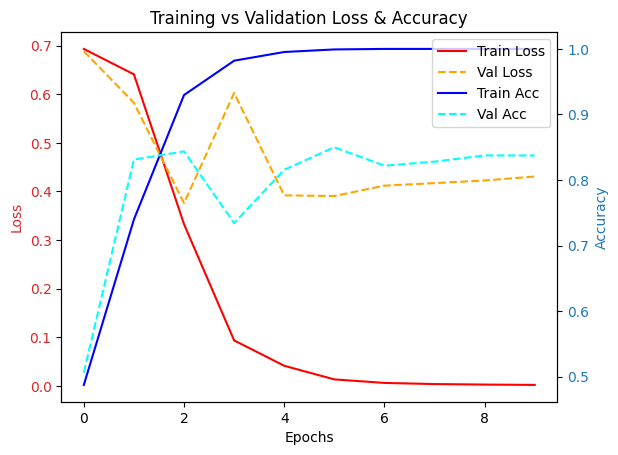

In [30]:
# Entraînement du modèle MLP
train_model2(mlp_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


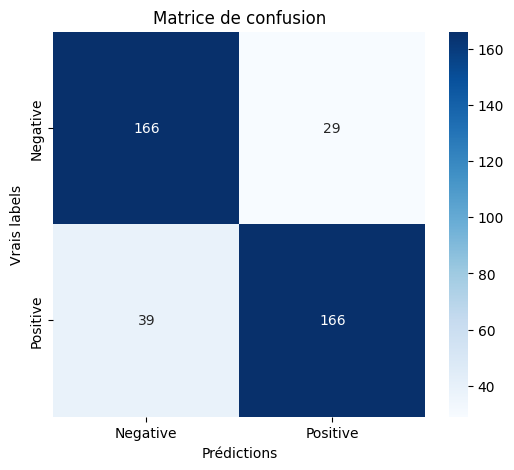

In [31]:
# Appel de la fonction pour afficher la matrice de confusion
plot_confusion_matrix(mlp_model, test_loader)

In [32]:
# Evaluation du modèle MLP
mlp_acc, mlp_precision, mlp_recall, mlp_f1 = evaluate_model(mlp_model, test_loader, criterion)


In [33]:
mlp_acc

0.83

## CNN

In [34]:
# Définition du modèle CNN
class CNN_Text(nn.Module):
    def __init__(self, filter_sizes, num_filters, dropout=0.5):
        super(CNN_Text, self).__init__()

        # Conv layers (1D convolutions)
        self.convs = nn.ModuleList([
            nn.Conv1d(1, num_filters, kernel_size=fs) for fs in filter_sizes
        ])

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(num_filters * len(filter_sizes), 1)  # Sortie unique pour classification binaire

    def forward(self, x):
        # Appliquer les convolutions (chaque filtre avec ReLU)
        conv_outs = []
        for conv in self.convs:
            conv_out = conv(x)
            conv_out = torch.relu(conv_out)
            conv_out = torch.max(conv_out, dim=2)[0]  # Max pooling
            conv_outs.append(conv_out)

        # Concaténer les sorties de convolution
        x = torch.cat(conv_outs, dim=1)

        # Appliquer le dropout
        x = self.dropout(x)

        # Appliquer la couche fully connected
        x = self.fc(x)

        return x

In [35]:

# Convertir les données combinées en tensors PyTorch
X_train_combined_tensor = torch.tensor(X_train_combined, dtype=torch.float32)
X_test_combined_tensor = torch.tensor(X_test_combined, dtype=torch.float32)

# Ajouter une dimension pour le canal (1D)
X_train_combined_tensor = X_train_combined_tensor.unsqueeze(1)  # Shape: [batch_size, 1, feature_size]
X_test_combined_tensor = X_test_combined_tensor.unsqueeze(1)

# Convertir les labels en tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Créer des DataLoaders pour l'entraînement et le test
train_data = TensorDataset(X_train_combined_tensor, y_train_tensor)
test_data = TensorDataset(X_test_combined_tensor, y_test_tensor)

train_loader_cnn = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader_cnn = DataLoader(test_data, batch_size=32, shuffle=False)


In [36]:
# Définir le modèle CNN
num_classes = 1
filter_sizes = [5, 6, 7]
num_filters = 256

cnn_model = CNN_Text(filter_sizes, num_filters, dropout=0.5)

# Fonction de perte et optimiseur
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.1)

Epoch 1, Loss: 1.1560, Accuracy: 0.4906
Epoch 2, Loss: 0.7007, Accuracy: 0.4875
Epoch 3, Loss: 0.6940, Accuracy: 0.5162
Epoch 4, Loss: 0.6954, Accuracy: 0.4950
Epoch 5, Loss: 0.6946, Accuracy: 0.4769


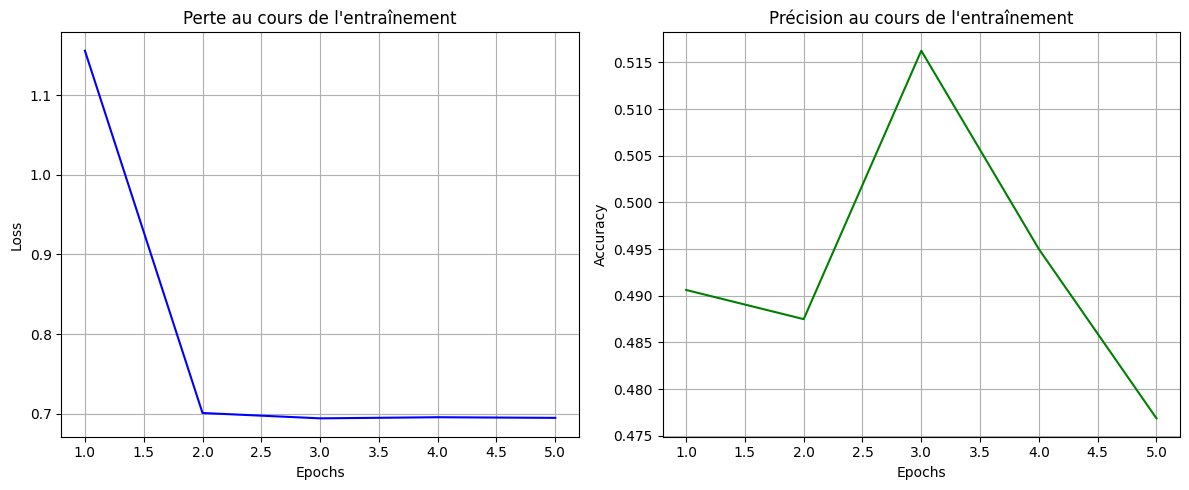

In [75]:
train_model(cnn_model, train_loader_cnn, criterion, optimizer, epochs=5)

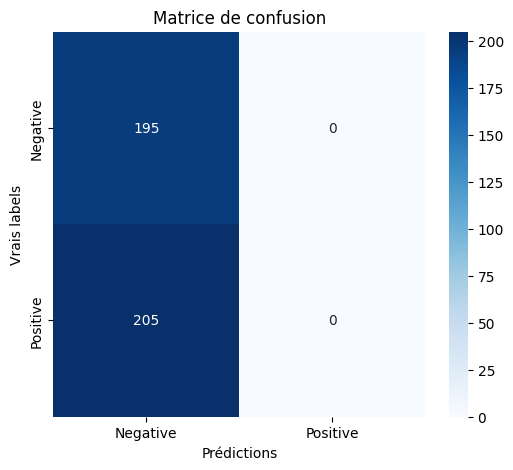

In [37]:
plot_confusion_matrix(cnn_model, test_loader_cnn)

In [38]:
#Evaluation du modèle CNN
cnn_acc, cnn_precision, cnn_recall, cnn_f1 = evaluate_model(cnn_model, test_loader_cnn, criterion)


In [39]:
cnn_acc

0.4875

# LSTM

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Hypothèse : X_train_combined est une matrice numpy 2D (n_samples, n_features)
# et y_train est un vecteur de labels

# Paramètres
n_features = X_train_combined.shape[1]  # Nombre de caractéristiques combinées
n_classes = len(set(y_train))  # Nombre de classes

# Reshape pour être compatible avec LSTM (samples, timesteps, features)
X_train_reshaped = X_train_combined.reshape((X_train_combined.shape[0], 1, X_train_combined.shape[1]))
# Reshape X_test_combined before prediction to match the expected input shape
X_test_reshaped = X_test_combined.reshape((X_test_combined.shape[0], 1, X_test_combined.shape[1]))


# Split en train/val
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_train_reshaped, y_train, test_size=0.2, random_state=42)

# Création du modèle LSTM
model = Sequential([
    Input(shape=(1, n_features)),  # Une seule étape temporelle avec plusieurs features
    LSTM(128, return_sequences=False),  # LSTM avec 128 unités
    Dropout(0.5),  # Pour éviter l'overfitting
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')  # Classification multi-classes
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.4956 - loss: 0.6934 - val_accuracy: 0.6000 - val_loss: 0.6827
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.5503 - loss: 0.6796 - val_accuracy: 0.5188 - val_loss: 0.6572
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6789 - loss: 0.5985 - val_accuracy: 0.8313 - val_loss: 0.4836
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8874 - loss: 0.3417 - val_accuracy: 0.8500 - val_loss: 0.3665
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9551 - loss: 0.1536 - val_accuracy: 0.8469 - val_loss: 0.3626


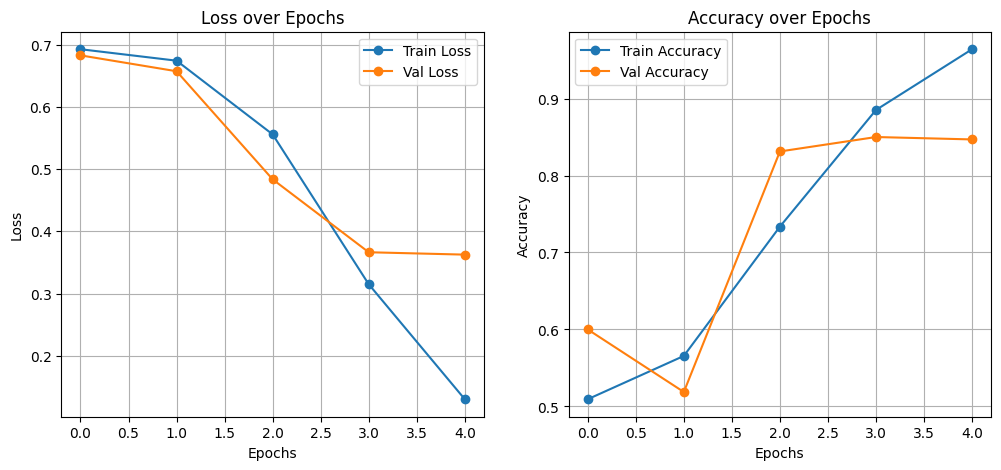

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


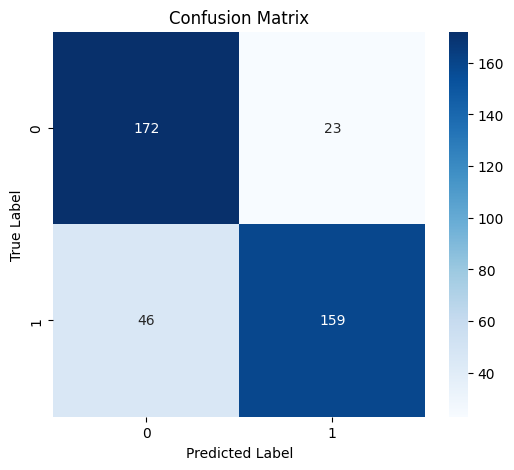

In [41]:

# Entraînement du modèle et récupération de l'historique
history = model.fit(X_train_lstm, y_train_lstm, validation_data=(X_val_lstm, y_val_lstm), epochs=5, batch_size=32)

# Tracer la courbe de perte et d'accuracy
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid()

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid()

plt.show()

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test_reshaped)
y_pred_classes = y_pred.argmax(axis=1)  # Convertir les probabilités en classes

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Prédictions sur les données de validation
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir en labels

# Calcul des métriques
lstm_acc = accuracy_score(y_test, y_pred_classes)
lstm_precision = precision_score(y_test, y_pred_classes, average='weighted')
lstm_recall = recall_score(y_test, y_pred_classes, average='weighted')
lstm_f1 = f1_score(y_test, y_pred_classes, average='weighted')


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [43]:
lstm_acc

0.8275

## Régression logistique

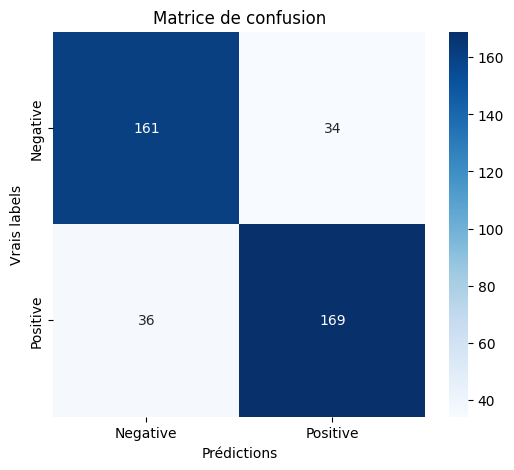

In [44]:
# Évaluation du modèle de régression logistique
clf = LogisticRegression()
clf.fit(X_train_combined, y_train)
log_preds = clf.predict(X_test_combined)
log_acc = accuracy_score(y_test, log_preds)
log_precision = precision_score(y_test, log_preds)
log_recall = recall_score(y_test, log_preds)
log_f1 = f1_score(y_test, log_preds)

def plot_confusion_matrix2(model, X_test, y_test):

    y_pred = model.predict(X_test)  # Get predictions from the model

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vrais labels')
    plt.title('Matrice de confusion')
    plt.show()


plot_confusion_matrix2(clf, X_test_combined, y_test)


In [45]:
log_acc

0.825

## Comparaison des modèles

In [46]:
# Créer un DataFrame pour la comparaison des résultats
comparison_df = pd.DataFrame({
    'Model': ['MoE', 'Logistic Regression', 'MLP', 'CNN', 'LSTM'],
    'Accuracy': [moe_acc, log_acc, mlp_acc, cnn_acc, lstm_acc],
    'Precision': [moe_precision, log_precision, mlp_precision, cnn_precision, lstm_precision],
    'Recall': [moe_recall, log_recall, mlp_recall, cnn_recall, lstm_recall],
    'F1 Score': [moe_f1, log_f1, mlp_f1, cnn_f1, lstm_f1]
})

# Afficher le tableau comparatif
print(comparison_df)


                 Model  Accuracy  Precision    Recall  F1 Score
0                  MoE    0.8050   0.843243  0.760976  0.800000
1  Logistic Regression    0.8250   0.832512  0.824390  0.828431
2                  MLP    0.8300   0.851282  0.809756  0.830000
3                  CNN    0.4875   0.000000  0.000000  0.000000
4                 LSTM    0.8275   0.832367  0.827500  0.827177


Epoch 1, Loss: 0.6879
Epoch 2, Loss: 1.4145
Epoch 3, Loss: 0.6445
Epoch 4, Loss: 0.9042
Epoch 5, Loss: 0.7474
Epoch 6, Loss: 0.5978
Epoch 7, Loss: 0.5900
Epoch 8, Loss: 0.6407
Epoch 9, Loss: 0.6550
Epoch 10, Loss: 0.6220
Epoch 11, Loss: 0.5782
Epoch 12, Loss: 0.5521
Epoch 13, Loss: 0.5443
Epoch 14, Loss: 0.5435
Epoch 15, Loss: 0.5390


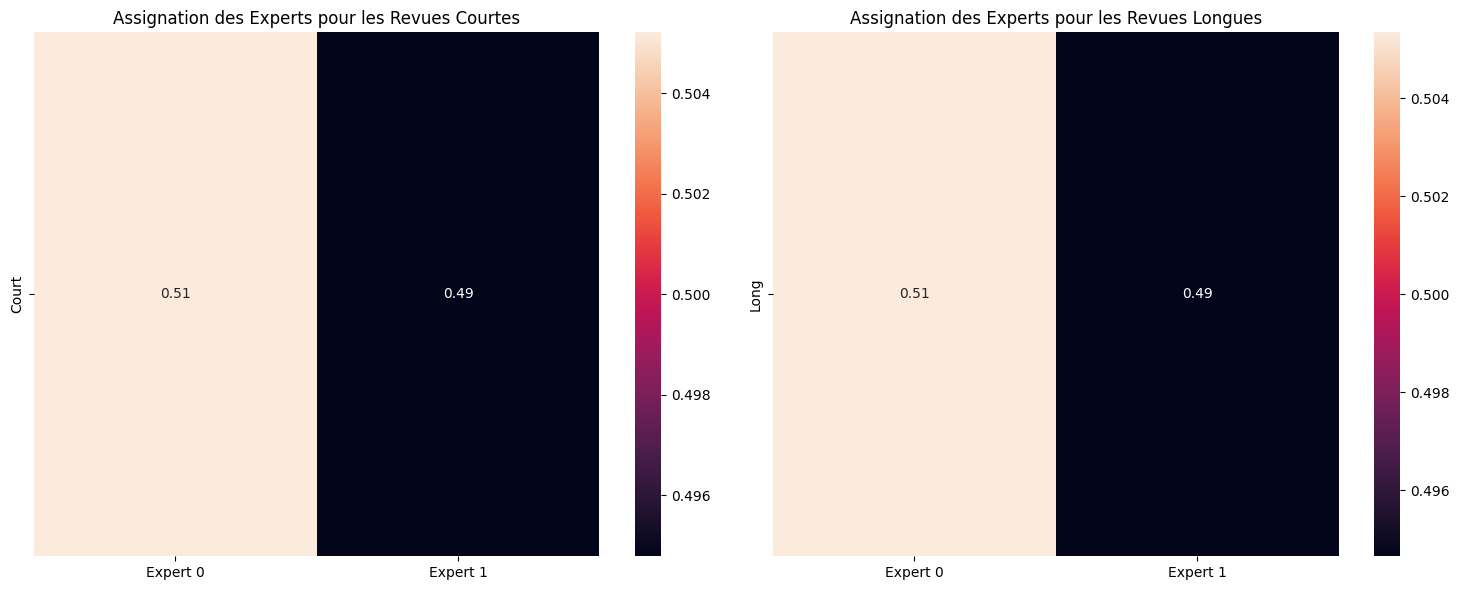

In [85]:

# Définir le modèle MixtureOfExperts avec gate output en sortie
class MixtureOfExperts(nn.Module):
    def __init__(self, input_dim, num_experts=2):
        super(MixtureOfExperts, self).__init__()
        self.experts = nn.ModuleList([nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        ) for _ in range(num_experts)])
        self.gate = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        gate_outputs = torch.softmax(self.gate(x), dim=1)
        expert_outputs = torch.cat([expert(x).unsqueeze(2) for expert in self.experts], dim=2)
        output = torch.sum(gate_outputs.unsqueeze(2) * expert_outputs, dim=2).squeeze(1)
        return output.sum(dim=1, keepdim=True), gate_outputs


# Préparer les données (s'assurer d'avoir les bonnes variables)
data['length'] = data['text'].apply(lambda x: len(x.split()))  # Nombre de mots
data['length_category'] = (data['length'] >= 200).astype(int)  # 0=Court (<200 mots), 1=Long (>=200 mots)

X_train_combined_tensor = torch.tensor(X_train_combined, dtype=torch.float32)
y_sentiment = torch.tensor(data.loc[X_train.index, 'label'].values)
y_length = torch.tensor(data.loc[X_train.index, 'length_category'].values)

# Instancier le modèle, la fonction de perte et l'optimiseur
model = MixtureOfExperts(input_dim=X_train_combined.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entraîner le modèle
for epoch in range(15):
    optimizer.zero_grad()
    output, gating_weights = model(X_train_combined_tensor)
    loss = criterion(output, y_length.unsqueeze(1).type(torch.float))
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Extraire les poids de la porte d'entrée
with torch.no_grad():
    _, gating_weights = model(X_train_combined_tensor)

gating_weights_np = gating_weights.numpy()

# Visualisation de l'affectation des experts pour les revues longues et courtes
plt.figure(figsize=(15, 6))

# Assignation des experts pour les revues courtes (length_category == 0)
plt.subplot(1, 2, 1)
short_reviews_weights = gating_weights_np[y_length == 0].mean(axis=0)  # Moyenne des poids pour les revues courtes
sns.heatmap(
    short_reviews_weights.reshape(1, -1),  # Redimensionner en 2D pour heatmap
    annot=True,
    xticklabels=[f"Expert {i}" for i in range(2)],
    yticklabels=["Court"]
)
plt.title("Assignation des Experts pour les Revues Courtes")

# Assignation des experts pour les revues longues (length_category == 1)
plt.subplot(1, 2, 2)
long_reviews_weights = gating_weights_np[y_length == 1].mean(axis=0)  # Moyenne des poids pour les revues longues
sns.heatmap(
    long_reviews_weights.reshape(1, -1),
    annot=True,
    xticklabels=[f"Expert {i}" for i in range(2)],
    yticklabels=["Long"]
)
plt.title("Assignation des Experts pour les Revues Longues")

plt.tight_layout()
plt.show()


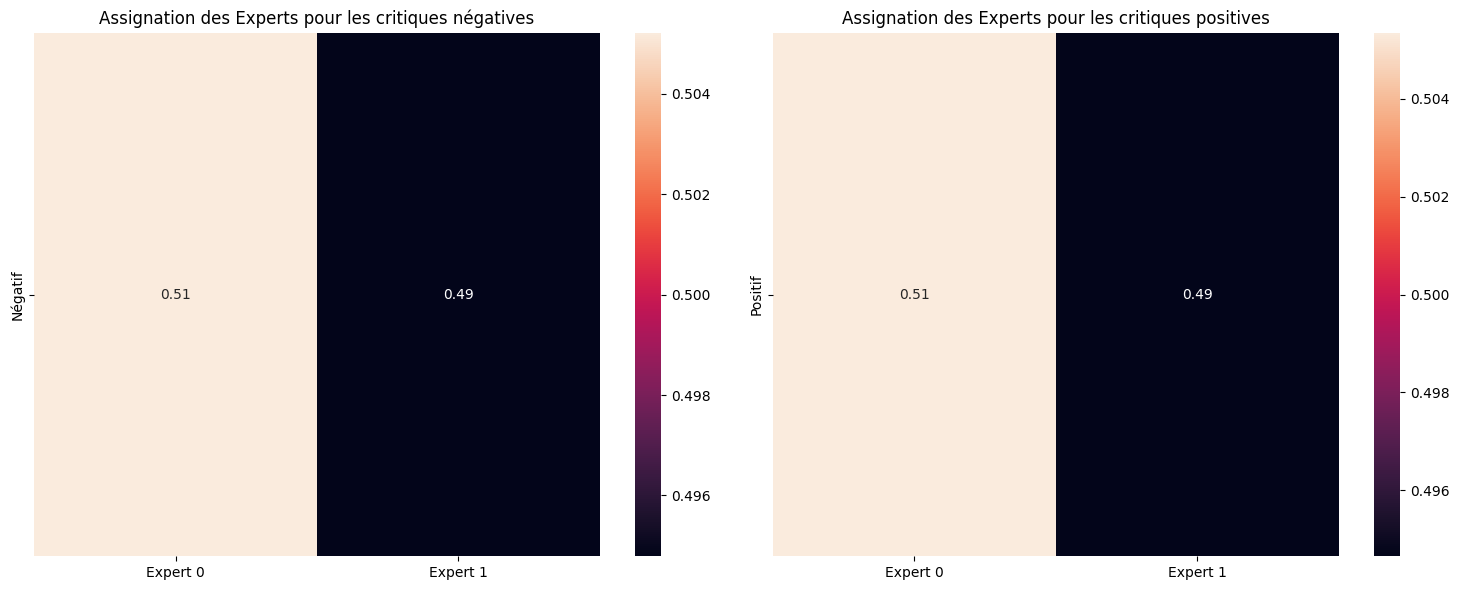

In [86]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
neg_reviews_weights = gating_weights_np[y_sentiment[:gating_weights_np.shape[0]] == 0].mean(axis=0)
sns.heatmap(
    short_reviews_weights.reshape(1, -1),
    annot=True,
    xticklabels=[f"Expert {i}" for i in range(2)],
    yticklabels=["Négatif"]
)
plt.title("Assignation des Experts pour les critiques négatives")

# Assignation des experts pour les critiques positives
plt.subplot(1, 2, 2)
pos_reviews_weights = gating_weights_np[y_sentiment[:gating_weights_np.shape[0]] == 1].mean(axis=0)
sns.heatmap(
    long_reviews_weights.reshape(1, -1),
    annot=True,
    xticklabels=[f"Expert {i}" for i in range(2)],
    yticklabels=["Positif"]
)
plt.title("Assignation des Experts pour les critiques positives")

plt.tight_layout()
plt.show()

In [87]:
# Vérification des poids de la porte pour quelques échantillons
with torch.no_grad():
    _, gating_weights = model(X_train_combined_tensor)

# Afficher les poids de la porte pour quelques échantillons
print(gating_weights[:10])

tensor([[0.5060, 0.4940],
        [0.5037, 0.4963],
        [0.5051, 0.4949],
        [0.5037, 0.4963],
        [0.5014, 0.4986],
        [0.5008, 0.4992],
        [0.5031, 0.4969],
        [0.5050, 0.4950],
        [0.5064, 0.4936],
        [0.5010, 0.4990]])


# Visualizing Decision Boundaries and Routing Mechanism

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_decision_boundaries(model, X, y):

    # Créer une grille de points pour l'évaluation du modèle
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Si votre modèle attend 8500 caractéristiques, répliquer les points dans la grille pour correspondre
    grid_points_expanded = np.hstack([grid_points, np.zeros((grid_points.shape[0], 8500 - 2))])  # Compléter avec des zéros pour atteindre 8500 dimensions

    with torch.no_grad():
        # Convertir la grille en tenseur et passer dans le modèle
        grid_tensor = torch.tensor(grid_points_expanded, dtype=torch.float32)

        gate_outputs = torch.softmax(model.gate(grid_tensor), dim=1)  # Obtenir les probabilités de la porte
        expert_outputs = torch.cat([expert(grid_tensor).unsqueeze(2) for expert in model.experts], dim=2)
        output = torch.sum(gate_outputs.unsqueeze(2) * expert_outputs, dim=2)

        # Convertir la sortie en prédictions
        #predictions = (output.squeeze() > 0).numpy().reshape(xx.shape)
        predictions = torch.argmax(output, dim=1).cpu().numpy().reshape(xx.shape)

    # Afficher les frontières de décision
    plt.contourf(xx, yy, predictions, alpha=0.8, cmap=plt.cm.Paired)

    # Afficher les points de données projetés
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, edgecolors='k')
    plt.title("Decision Boundaries and Expert Assignments")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Visualiser les frontières de décision sur les données de test
visualize_decision_boundaries(moe_model, X_test_combined, y_test)
